In [29]:
from molmap.model import RegressionEstimator, MultiClassEstimator, MultiLabelEstimator
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from chembench import dataset
from sklearn.utils import shuffle 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from molmap import MolMap
import molmap

def Rdsplit(df, random_state = 888, split_size = [0.8, 0.1, 0.1]):
    base_indices = np.arange(len(df)) 
    base_indices = shuffle(base_indices, random_state = random_state) 
    nb_test = int(len(base_indices) * split_size[2]) 
    nb_val = int(len(base_indices) * split_size[1]) 
    test_idx = base_indices[0:nb_test] 
    valid_idx = base_indices[(nb_test):(nb_test+nb_val)] 
    train_idx = base_indices[(nb_test+nb_val):len(base_indices)] 
    print(len(train_idx), len(valid_idx), len(test_idx)) 
    return train_idx, valid_idx, test_idx 

In [2]:
data = dataset.load_BACE()

total samples: 1513


In [3]:
bitsinfo = molmap.feature.fingerprint.Extraction().bitsinfo

In [4]:
bitsinfo.Subtypes.unique()

array(['MorganFP', 'RDkitFP', 'AtomPairFP', 'TorsionFP', 'AvalonFP',
       'EstateFP', 'MACCSFP', 'PharmacoErGFP', 'PharmacoPFP', 'PubChemFP',
       'MHFP6', 'MAP4'], dtype=object)

In [5]:
flist = bitsinfo[bitsinfo.Subtypes.isin(['PubChemFP'])].IDs.tolist()
# flist= [] means using all of the types of fingerprint

mp = MolMap(ftype = 'fingerprint', fmap_type = 'scatter', flist = flist) # 

In [6]:
mp.fit(method = 'umap',  min_dist = 0.1, n_neighbors = 15, verbose = 0)

2021-03-31 10:53:51,323 - INFO - [bidd-molmap] - Applying naive scatter feature map...
2021-03-31 10:53:51,332 - INFO - [bidd-molmap] - Finished


In [7]:
X = mp.batch_transform(data.x)

100%|##########| 1513/1513 [00:56<00:00, 26.82it/s]


In [8]:
Y = pd.get_dummies(data.df['Class']).values
Y.shape

(1513, 2)

In [9]:
train_idx, valid_idx, test_idx  = Rdsplit(data.df, random_state = 888)
trainX = X[train_idx]
trainY = Y[train_idx]
validX = X[valid_idx]
validY = Y[valid_idx]
testX = X[test_idx]
testY = Y[test_idx]

1211 151 151


In [10]:
# define your model
clf = MultiClassEstimator(n_outputs=trainY.shape[1], metric='ROC', 
                          fmap_shape1 = trainX.shape[1:], dense_layers = [128, 64],  gpuid = 0) 

MultiClassEstimator(gpuid='0')


In [11]:
# fit your model
clf.fit(trainX, trainY, validX, validY )

epoch: 0001, loss: 0.6911 - val_loss: 0.6806; auc: 0.7934 - val_auc: 0.7162                                                                                                    
epoch: 0002, loss: 0.6756 - val_loss: 0.6698; auc: 0.8256 - val_auc: 0.7584                                                                                                    
epoch: 0003, loss: 0.6617 - val_loss: 0.6588; auc: 0.8383 - val_auc: 0.7675                                                                                                    
epoch: 0004, loss: 0.6472 - val_loss: 0.6461; auc: 0.8424 - val_auc: 0.7741                                                                                                    
epoch: 0005, loss: 0.6346 - val_loss: 0.6325; auc: 0.8471 - val_auc: 0.7826                                                                                                    
epoch: 0006, loss: 0.6170 - val_loss: 0.6224; auc: 0.8508 - val_auc: 0.7867                                             

MultiClassEstimator(gpuid='0')

## plot training history

<AxesSubplot:>

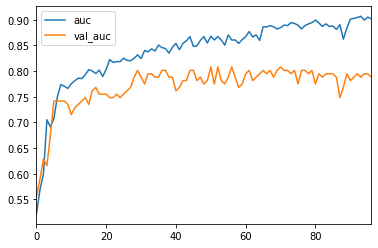

In [12]:
pd.DataFrame(clf.history.history)[['accuracy', 'val_accuracy']].rename(columns={'accuracy':'auc', 'val_accuracy':'val_auc'}).plot()

<AxesSubplot:>

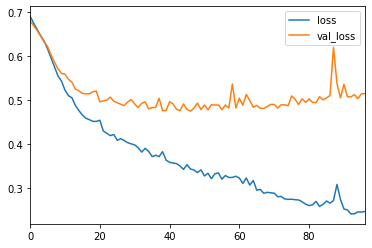

In [13]:
pd.DataFrame(clf.history.history)[['loss', 'val_loss']].plot()

In [14]:
print('Best epochs: %.2f, Best loss: %.2f' % (clf._performance.best_epoch, clf._performance.best))

Best epochs: 46.00, Best loss: 0.47


# performance on  test set

In [15]:
auc = clf.score(testX, testY)

In [16]:
auc

0.8935828877005347

In [23]:
df_pred = pd.DataFrame([testY[:, 0], clf.predict_proba(testX)[:,0]]).T
df_pred.columns=['y_true', 'y_pred_prob']

In [24]:
df_pred.head(5)

,y_true,y_pred_prob
0,1.0,0.961530
1,0.0,0.479526
2,1.0,0.977022
3,1.0,0.839713
4,0.0,0.187806


<AxesSubplot:>

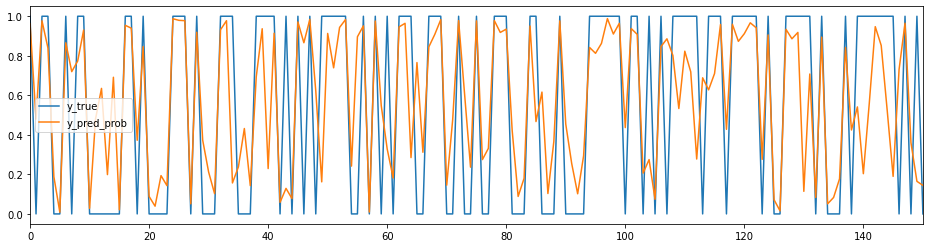

In [27]:
df_pred.plot(figsize=(16, 4))

In [28]:
df_pred.corr()

,y_true,y_pred_prob
y_true,1.000000,0.679407
y_pred_prob,0.679407,1.000000
